In [2]:
import pandas as pd
import tokenize
from keras.preprocessing.text import text_to_word_sequence
import matplotlib.pyplot as plt
import seaborn as sns
import preprocessor as p
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.SMILEY, p.OPT.NUMBER)
sns.set_style('darkgrid')

### Overview

In [3]:
df = pd.read_csv('../../data/raw/tesla_tweets.csv')
df.sample(5)

,Date & Time,Profile Picture Link,Twitter ID,Tweet Text,Tweet Link
97923,"August 28, 2022 at 06:16PM",http://pbs.twimg.com/profile_images/152351455...,@Sk58898884,What's EIGHT got to do with ELON and ETHAX'?\n...,https://twitter.com/Sk58898884/status/15638858...
47108,"June 18, 2022 at 10:11AM",http://pbs.twimg.com/profile_images/139883958...,@JRBenton35,RT @GerberKawasaki: WSJ reporting that interne...,https://twitter.com/JRBenton35/status/15380341...
91664,"August 19, 2022 at 03:15PM",http://pbs.twimg.com/profile_images/143010254...,@ALakrintis,#Tesla #China Denies Made-in-China Model 3s to...,https://twitter.com/ALakrintis/status/15605785...
115499,"September 22, 2022 at 08:00AM",http://pbs.twimg.com/profile_images/324475275...,@daboogah,after bribing a friend for months to get me th...,https://twitter.com/daboogah/status/1572805478...
67725,"July 17, 2022 at 03:14AM",http://pbs.twimg.com/profile_images/150388753...,@Futureistody,Elon Musk arrived in #Mykonos #Greece 🇬🇷\n\nEn...,https://twitter.com/Futureistody/status/154843...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152000 entries, 0 to 151999
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Date & Time           152000 non-null  object
 1   Profile Picture Link  152000 non-null  object
 2   Twitter ID            152000 non-null  object
 3   Tweet Text            152000 non-null  object
 4   Tweet Link            152000 non-null  object
dtypes: object(5)
memory usage: 5.8+ MB


Tras obtener información preliminar del dataframe, se obtienen diferentes insights. Existen 5 columnas (siendo todas de tipo string), en las que se recoge la siguiente información:
- **Date & Time**: Fecha y hora de la publicación del tweet. La variable de tiempo es de tipo string, por lo que será necesario convertirla a tipo datetime en el preprocesamiento. El formato de la fecha no sigue ninguna de las convenciones que conoce elk autor del script.
- **Profile Picture Link**: Link al contenedor donde está alojada la foto de perfil de usuario que ha publicado el post. Esta información no es relevante para el análisis, por lo que se eliminará en el preprocesamiento.
- **Twitter Id**: Handle de cada usuario que ha publicado el tweet. No es de interés de cara al análisis.
- **Tweet Text**: Texto del tweet. Es la información más relevante de cara al análisis.
- **Tweet Link**: Link al tweet. No es de interés de cara al análisis, pero es útil para identificar de forma unívoca cada post, por lo que no se elimina en el preprocesado.

Se procede a eliminar las columnas que no son de interés para facilitar el análisis del resto de aquellas que sí lo son. No se eliminarán del archivo original.

In [5]:
df.drop(['Profile Picture Link', 'Twitter ID'], axis=1, inplace=True)
df.isnull().sum()

Date & Time    0
Tweet Text     0
Tweet Link     0
dtype: int64

No se obtienen valores nulos en ninguna de las columnas, por lo que no es necesario realizar el de este tipo de valores.

## Métricas



### Palabras y caracteres por tweet

A continuación se calcularán una serie de métricas que pueden resultar de interés para entender mejor el dataset.  

In [6]:
# obtener numero de caracteres y palabras de cada tweet

def count_words(text : str) -> int:
    return len(text_to_word_sequence(text))

df['Tweet Length'] = df['Tweet Text'].apply(len)
df['Tweet Word Count'] = df['Tweet Text'].apply(count_words)

df.sample(5)



,Date & Time,Tweet Text,Tweet Link,Tweet Length,Tweet Word Count
36417,"June 03, 2022 at 12:16PM",Tesla pauses all hiring. \n\nIts chief Elon Mu...,https://twitter.com/bsindia/status/15326298032...,163,27
135194,"October 19, 2022 at 08:21PM",RT @ROTANGll: I wonder what conman is thinking...,https://twitter.com/tslaqtwin/status/158277658...,107,16
66197,"July 15, 2022 at 12:17AM",RT @ProfStrachan: Electric cars sold in #UK pa...,https://twitter.com/OrbPlanet/status/154766906...,298,38
99510,"August 31, 2022 at 12:12AM",$TSLA #Tesla shares stunning images of extreme...,https://twitter.com/___L__A___/status/15647000...,108,17
91494,"August 19, 2022 at 09:16AM",RT @NikkeiAsia: Tesla has warned of an impact ...,https://twitter.com/BibiSpielberg_/status/1560...,238,37


Numero de tweets: 152000
Numero medio de palabras por tweet: 29.95128947368421
Numero medio de caracteres por tweet: 196.7343552631579
Desviacion estandar de palabras por tweet: 13.326014064779367
Desviacion estandar de caracteres por tweet: 84.92989581522124


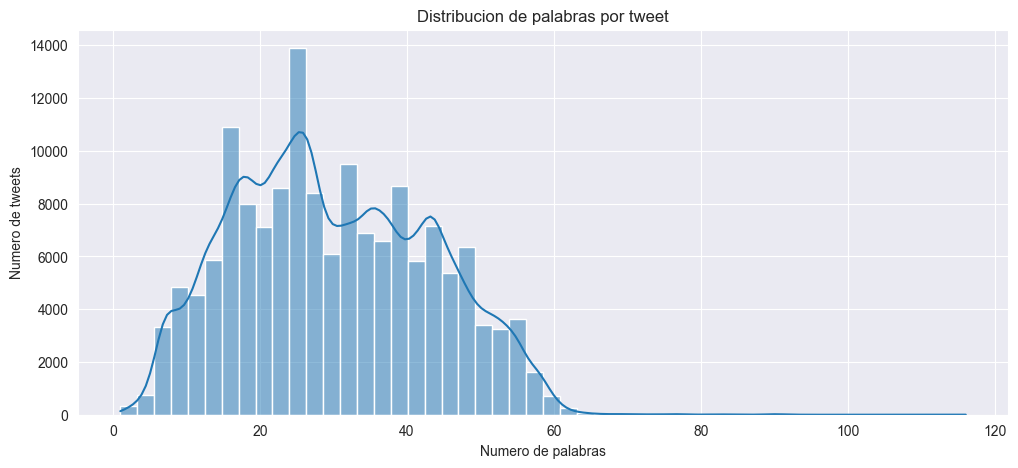

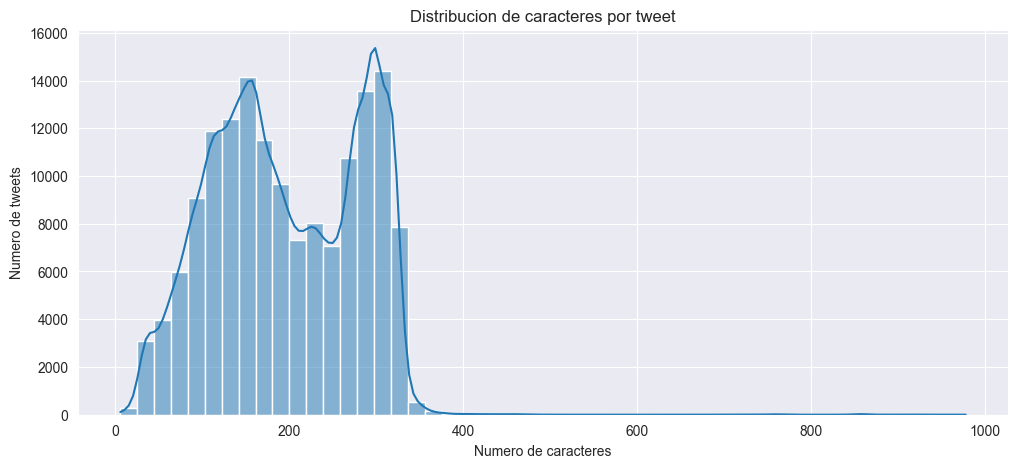

In [7]:
print(f"Numero de tweets: {len(df)}")
print(f"Numero medio de palabras por tweet: {df['Tweet Word Count'].mean()}")
print(f"Numero medio de caracteres por tweet: {df['Tweet Length'].mean()}")
print(f'Desviacion estandar de palabras por tweet: {df["Tweet Word Count"].std()}')
print(f'Desviacion estandar de caracteres por tweet: {df["Tweet Length"].std()}')

# visualizaciones

plt.figure(figsize=(12, 5))
sns.histplot(df['Tweet Word Count'], kde=True, bins=50)
plt.title('Distribucion de palabras por tweet')
plt.xlabel('Numero de palabras')
plt.ylabel('Numero de tweets')
plt.show();


plt.figure(figsize=(12, 5))
sns.histplot(df['Tweet Length'], kde=True, bins=50)
plt.title('Distribucion de caracteres por tweet')
plt.xlabel('Numero de caracteres')
plt.ylabel('Numero de tweets')
plt.show();


En los gráficos superiores se obtienen las distribuciones de número de palabras y caracteres en cada tweet. Mientras la distribución de palabras es bastante homogénea, acercándose mucho a una distribución normal, la distribución de caracteres cuenta otra historia. Se observan dos picos, uno en torno a los 140 caracteres y otro en torno a los 280, que se corresponde con el límite de caracteres de un tweet antes y después de 2017, al haber ampliado la plataforma el límite de caracteres por tweet. Por la distribución de caracteres por tweet salta a la vista que pueden existir tweets que superen el límite de caracteres, por lo que se procede a comprobarlo.

In [8]:
mask = df['Tweet Text'].str.len() > 280

print(f"Numero de tweets con mas de 280 caracteres: {len(df[mask])}")
df[mask].sort_values(by='Tweet Word Count', ascending=False).head(10)

Numero de tweets con mas de 280 caracteres: 34954


,Date & Time,Tweet Text,Tweet Link,Tweet Length,Tweet Word Count
4283,"April 16, 2022 at 04:14AM",RT @Alan83bullB: @3lond3_3arbie @ALaN83BuLL @h...,https://twitter.com/3lond3_3arbie/status/15151...,950,116
2558,"April 13, 2022 at 07:11PM",RT @hmg83bull: @ALaN83BuLL @Alan83bullB @3lond...,https://twitter.com/YvesAla72210826/status/151...,926,116
3934,"April 15, 2022 at 05:14PM",RT @Alan83bullB: @3lond3_3arbie @ALaN83BuLL @h...,https://twitter.com/hmg83bull/status/151494766...,950,116
76398,"July 29, 2022 at 05:57AM",RT @musicphantom69: @BanksyMaximo @CCuntamed @...,https://twitter.com/Isabel10485817/status/1552...,953,114
2223,"April 13, 2022 at 07:18AM",@ALaN83BuLL @Alan83bullB @3lond3_3arbie @Alexi...,https://twitter.com/hmg83bull/status/151407298...,911,114
3531,"April 15, 2022 at 03:16AM",RT @Alan83bullB: @ALaN83BuLL @Petriot15 @JJemi...,https://twitter.com/hmg83bull/status/151473686...,883,106
54114,"June 28, 2022 at 03:53AM",RT @conkers3: @claudiohfox @lithiumdude80 @pla...,https://twitter.com/Gambiste1/status/154156282...,898,106
80823,"August 04, 2022 at 10:15AM",@eretico_l @modamanager @laperlaneranera @Anna...,https://twitter.com/Hero9004/status/1555067408...,940,102
3275,"April 14, 2022 at 07:16PM",RT @YvesAla72210826: @Alan83bullB @AlexiaAnnuk...,https://twitter.com/Drmughalazam/status/151461...,755,100
53677,"June 27, 2022 at 01:14PM",RT @conkers3: @agroasx @claudiohfox @Ramraj35h...,https://twitter.com/TNR_Gold/status/1541341726...,889,100


In [9]:
df[mask].sort_values(by='Tweet Word Count', ascending=False).iloc[0]['Tweet Text']

'RT @Alan83bullB: @3lond3_3arbie @ALaN83BuLL @hmg83bull @AlexiaAnnuk @Aa_ban1 @nbea_h @Zar_43 @IsoaG @hRp__5 @Sasha_1I @ZendaJade @learockerita @R_M_alex21 @faragdomyat @WileyYurem @Alit1_Kawulo @smhj28486726 @Drmughalazam @Sagita81774027 @Sound_of_power @MarthaCandia21 @StephenCurry30 @imUrB00gieman @MargaretAUGrad @Cliff723 @JohnC32116200 @SrivatsPrakash @QueenHollyFayO1 @Mazichukslyon9 @DrStevenGreer @InnaVernikov @Christo20234340 @ImDee45 @BrightFame34 @YouTube @nflcommish @gianis_1 @Ezhilar11174545 @Lauria1960 @TIGERWOODSRENEW @AkaGross @BraakselK @Mike_stingray58 @CNBC @YvesAla72210826 @DirexionLETFs @CNBCFastMoney @CubanMofo_ @PEOPLEBEREAL $TSLA ABC Major Correction = $300  \nSafe to Say Margin Will 🪦 You PlayBoy! Looking forward to those $TECS $SQQQ 📞 Accumulates by 🏦 Destroying your Equity like a 🐊 Chop Chop Chop \n\nSo indeed great idea Spending 💰 on Infrastructure #meta ➕ #Tesla 💋 \n\nhttps://t.co/D8MfeM7RAv https://t.co/fIyxXkdk9z'

Se comprueba que existen cerca de 35000 tweets (entorno a un 23% de la muestra) que superan el límite de caracteres. Esto se debe a que las menciones en Twitter no cuentan como caracteres, por lo que es posible que el texto de un tweet supere el límite de caracteres en el dataset. La mayoría de estos tweets simplemente se utilizan para atraer la atención de otros usuarios a través de las menciones, por lo que no se considera que sea un problema para el análisis. Las menciones a usuarios serán eliminadas en el preprocesamiento.

### Análisis de frecuencia de palabras

In [10]:
def clean_tweet(text : str) -> str:
    return p.clean(text)

def count_words() -> dict:
    word_dict = {}

    for tweet in df['Clean Tweet']:
        for word in text_to_word_sequence(tweet):
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1
    
    return word_dict


df['Clean Tweet'] = df['Tweet Text'].apply(clean_tweet)
word_dict = count_words()

print(f"Numero de palabras unicas: {len(word_dict)}")


Numero de palabras unicas: 104143


In [11]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

top_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)
filtered_words = [(word, count) for word, count in top_words if word.lower() not in stop_words]
filtered_words[:15]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('tesla', 188391),
 ('elonmusk', 26023),
 ('tsla', 24338),
 ('elon', 19213),
 ('model', 16163),
 ('musk', 13003),
 ('spacex', 12929),
 ('de', 12465),
 ('bitcoin', 11491),
 ('twitter', 11172),
 ('ev', 9464),
 ('amp', 9446),
 ('first', 8609),
 ('car', 8296),
 ('new', 7905)]

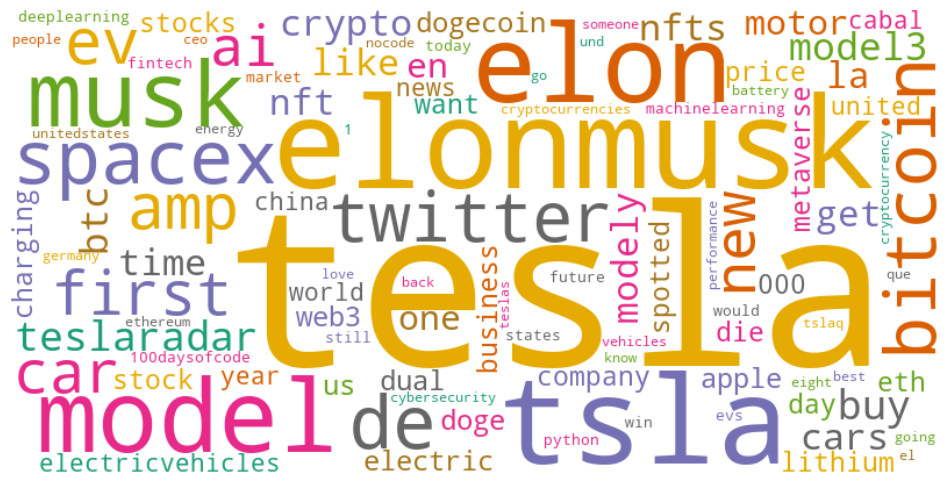

In [12]:

word_dict = {word: freq for word, freq in filtered_words}
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2', max_words=100).generate_from_frequencies(word_dict)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

Tras analizar las palabras mas frecuentes del dataset, se obtiene el resultado esperado. Se han limpiado los tweets de caracteres especiales, menciones, hashtags y demás conjunciones propias d la plataforma. Se ha descargado además una lista de stopwords en inglés para tratar de conseguir las palabras más relevantes para el estudio. Se aprecia que las palabras más frecuentes son las que se esperaban, englobando palabras como Tesla, Elon Musk, SpaceX, Bitcoin, Crypto, etc.

## Otras columnas

### Columna de Date & Time

In [13]:
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format='mixed') 
df['Date & Time'].dtype
print(f"Fecha del primer tweet: {df['Date & Time'].min()}")
print(f"Fecha del ultimo tweet: {df['Date & Time'].max()}")
print(f"Numero de dias: {df['Date & Time'].max() - df['Date & Time'].min()}")


Fecha del primer tweet: 2022-04-10 19:44:00
Fecha del ultimo tweet: 2022-11-12 15:11:00
Numero de dias: 215 days 19:27:00


Tras convertir las fechas a tipo datetime, se obtiene un periodo de tiempo de 215 días, confirmando lo descrito en la página del dataset en Kaggle.

### Columna de Twitter Link

Como se espera que la columna sea única por cada tweet y no contiene información relevante para el análisis, se va a comprobar que no existan duplicados.

In [14]:
print(f'Número de links duplicados: {df["Tweet Link"].duplicated().sum()}')

Número de links duplicados: 0
